In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
gbq_query = """
  SELECT * FROM `graphite-store-258114.dragonHacks2020.pollution`;
"""

In [4]:
pollution = pd.read_gbq(gbq_query, project_id="graphite-store-258114")

Requesting query... ok.
Job ID: c461f1c5-32b9-4e6f-9a0d-0d8d54228da1
Query running...
Query done.
Cache hit.

Retrieving results...
Got 1746661 rows.

Total time taken 537.8 s.
Finished at 2020-02-23 16:39:18.


In [5]:
new_cols = []
for cols in pollution.columns:
    new_cols.append(cols.replace("_", " "))
    
pollution.columns = new_cols
pollution.columns

Index(['State Code', 'County Code', 'Site Num', 'Address', 'State', 'County',
       'City', 'Date Local', 'NO2 Units', 'NO2 Mean', 'NO2 1st Max Value',
       'NO2 1st Max Hour', 'NO2 AQI', 'O3 Units', 'O3 Mean',
       'O3 1st Max Value', 'O3 1st Max Hour', 'O3 AQI', 'SO2 Units',
       'SO2 Mean', 'SO2 1st Max Value', 'SO2 1st Max Hour', 'SO2 AQI',
       'CO Units', 'CO Mean', 'CO 1st Max Value', 'CO 1st Max Hour', 'CO AQI'],
      dtype='object')

In [6]:
pollution_bkp = pollution.copy()

In [7]:
pollution['Date Local'] = pd.to_datetime(pollution['Date Local'])
pollution = pollution[pollution['Date Local'] > '2010-12-31']

#Removing unnecessary columns
pollution.drop(columns=['State Code','County Code','Address','NO2 Units', 'NO2 Mean','NO2 1st Max Value', 'NO2 1st Max Hour', 'O3 Units', 'O3 Mean', 'O3 1st Max Value', 'O3 1st Max Hour', 'SO2 Units','SO2 Mean', 'SO2 1st Max Value', 'SO2 1st Max Hour', 'CO Units', 'CO Mean', 'CO 1st Max Value', 'CO 1st Max Hour'], inplace=True)
pollution.dropna(inplace=True) #drop null values

#Aggregate AQIs'
df = pollution.groupby(['Site Num', 'State','County','City','Date Local']).agg({'NO2 AQI':'mean','O3 AQI':'mean','SO2 AQI':'mean','CO AQI':'mean'})
df.reset_index(inplace=True)

#Checking if all cities have the data in all required years
df['year'] = pd.DatetimeIndex(df['Date Local']).year
inter = df.groupby('City').agg({'year': 'nunique'})
inter = inter.reset_index()
inter = inter[inter.year == 6]
uniqueCity = list(inter.City)

# #Removing the cities which don't have 6 years of data
df = df[df.City.isin(uniqueCity)]

# Aggregating to day-level
pollutants = ['no2_aqi', 'o3_aqi', 'so2_aqi', 'co_aqi']
agg_data = df.groupby('Date Local').mean().drop(['Site Num','year'], axis=1)
agg_data.index = pd.to_datetime(agg_data.index)
agg_data.columns = pollutants

#Splitting to train and test
train = agg_data[:'2015-10-01']
test = agg_data['2015-10-01':'2016-03-31']

# Forecasting data
# Fourier terms
fourier = pd.DataFrame(index=agg_data[:'2016-03-31'].index)

# Frequency is being set to 365.25 because we have leap years
fourier['sin_1'] = np.sin(2 * np.pi * fourier.index.dayofyear / 365.25)
fourier['cos_1'] = np.cos(2 * np.pi * fourier.index.dayofyear / 365.25)
fourier['sin_2'] = np.sin(4 * np.pi * fourier.index.dayofyear / 365.25)
fourier['cos_2'] = np.cos(4 * np.pi * fourier.index.dayofyear / 365.25)

fourier_train = fourier.iloc[:train.shape[0], :]
fourier_test = fourier.iloc[train.shape[0]-1:, :]

no2_arima = auto_arima(train['no2_aqi'], 
                       exogenous=fourier_train, 
                       start_p=1, 
                       start_q=0, 
                       stepwise=True, 
                       suppress_warnings=True, 
                       error_action='ignore')

o3_arima = auto_arima(train['o3_aqi'], 
                      exogenous=fourier_train, 
                      start_p=1, 
                      start_q=0,
                      stepwise=True, 
                      suppress_warnings=True)

so2_arima = auto_arima(train['so2_aqi'], 
                       exogenous=fourier_train,
                       start_p=1, 
                       start_q=0, 
                       stepwise=True, 
                       suppress_warnings=True,
                       error_action='ignore')

co_arima =  auto_arima(train['co_aqi'],
                       exogenous=fourier_train,
                       start_p=1, 
                       start_q=0, 
                       stepwise=True, 
                       suppress_warnings=True)


no2_predictions = no2_arima.predict(n_periods=test.shape[0], exogenous=fourier_test)
o3_predictions  = o3_arima.predict(n_periods=test.shape[0], exogenous=fourier_test)
so2_predictions = so2_arima.predict(n_periods=test.shape[0], exogenous=fourier_test)
co_predictions  = co_arima.predict(n_periods=test.shape[0], exogenous=fourier_test)
sarima_pred = pd.DataFrame(np.c_[no2_predictions, o3_predictions, so2_predictions, co_predictions],
                           columns=test.columns, 
                           index=test.index)
                           
                           
# Creating a dataframe to store arima scores

s_ix = pd.MultiIndex.from_tuples([('RMSE', 'SARIMA'), ('MAE', 'SARIMA')])
sarima_scores = pd.DataFrame(index=s_ix, columns=pollutants)

for pol in pollutants:
    pred = sarima_pred[pol]
    rmse = np.sqrt(mean_squared_error(test[pol], pred))
    mae = mean_absolute_error(test[pol], pred)
    sarima_scores.loc[:,pol] = [rmse, mae]

sarima_scores

,,no2_aqi,o3_aqi,so2_aqi,co_aqi
RMSE,SARIMA,0.918606,1.250869,3.242497,2.603772
MAE,SARIMA,0.749465,1.076977,2.579577,2.140714


In [11]:
import subprocess
import pickle
PICKLED_WRITE_PATH = "/content/datalab/write/"
BUCKET_NAME = "graphite-store-258114-aiplatform"

def upload_models(model, model_name):
    full_path = PICKLED_WRITE_PATH + model_name + ".pkl"
    with open(full_path, 'wb') as f:
        pickle.dump(model, f)
    
    # Upload the model to GCS
    cmd = ["gsutil", "cp", full_path, "gs://{0}/".format(BUCKET_NAME)]
    subprocess.call(cmd)
    
upload_models(no2_arima, "no2_arima")
upload_models(o3_arima, "o3_arima")
upload_models(so2_arima, "so2_arima")
upload_models(co_arima, "co_arima")

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


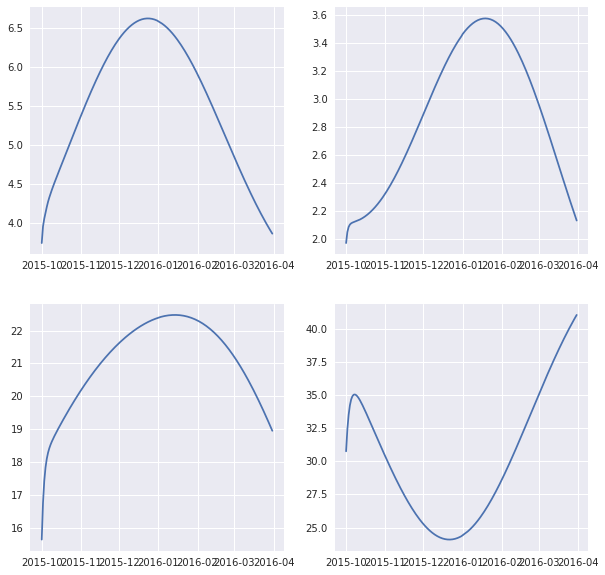

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches((10, 10))

ax[0][0].plot(sarima_pred['no2_aqi'])
ax[0][1].plot(sarima_pred['o3_aqi'])
ax[1][0].plot(sarima_pred['so2_aqi'])
ax[1][1].plot(sarima_pred['co_aqi'])

In [9]:
DEFAULT_TABLE = 'pollution'
PROJECT_NAME = 'graphite-store-258114'
PICKLED_READ_PATH = "/content/datalab/read/"


def get_gbq_query(bq_table_name):
    gbq_query = """
      SELECT * FROM `graphite-store-258114.dragonHacks2020.{0}`.format(bq_table_name);
    """

def readdata(resource, file_path="", bq_table=DEFAULT_TABLE):
    if file_path:
        pollution = pd.read_csv(path)
    elif bq_table:
        gbq_query = get_gbq_query(bq_table)
        pollution = pd.read_gbq(gbq_query, project_id=PROJECT_NAME)
    return pollution
    

def clean_column_names(old_cols):
    new_cols = []
    for cols in old_cols:
        new_cols.append(cols.replace("_", " "))
    return new_cols


def treatdata(df):
    # Data Cleaning
    df.columns = clean_column_names(df.columns)
    
    df = df[df['Date Local'] > '2010-12-31']
    df.drop(columns=['State Code','County Code','Address','NO2 Units', 'NO2 Mean','NO2 1st Max Value', 'NO2 1st Max Hour', 'O3 Units', 'O3 Mean', 'O3 1st Max Value', 'O3 1st Max Hour', 'SO2 Units','SO2 Mean', 'SO2 1st Max Value', 'SO2 1st Max Hour', 'CO Units', 'CO Mean', 'CO 1st Max Value', 'CO 1st Max Hour'], inplace=True)
    df.dropna(inplace = True)
    
    # Data Transforming
    df1 = df.groupby(['Site Num','State','County','City','Date Local']).agg({'NO2 AQI':'mean', 'O3 AQI':'mean', 'SO2 AQI':'mean', 'CO AQI':'mean'})
    df1.reset_index(inplace=True)
    
    #Filtering for cities which don't have data for the given time period
    df1['year'] = pd.DatetimeIndex(df1['Date Local']).year
    inter = df1.groupby('City').agg({'year': 'nunique'})
    inter = inter.reset_index()
    inter = inter[inter.year == 6]
    uniqueCity = inter.City.to_list()
    
    df1 = df1[df1.City.isin(uniqueCity)]
    
    #Aggregating to day-level
    pollutants = ['no2_aqi', 'o3_aqi', 'so2_aqi', 'co_aqi']
    agg_data = df1.groupby('Date Local').mean().drop(['Site Num','year'], axis=1)
    agg_data.index = pd.to_datetime(agg_data.index)
    agg_data.columns = pollutants
    return agg_data
  

def get_model(model_name):
    cmd = ["gsutil", "cp", "gs://{0}/{1}.pkl".format(BUCKET_NAME, model_name), PICKLED_READ_PATH]
    subprocess.call(cmd)
    full_path = PICKLED_READ_PATH + model_name + ".pkl"
    with open(full_path, 'rb') as f:
        model = pickle.load(f)
    return model
    

def modeldata(data, period=356):    
    
    fourier = pd.DataFrame(index=data.index)
    
    fourier['sin_1'] = np.sin(2 * np.pi * fourier.index.dayofyear / 365.25)
    fourier['cos_1'] = np.cos(2 * np.pi * fourier.index.dayofyear / 365.25)
    fourier['sin_2'] = np.sin(4 * np.pi * fourier.index.dayofyear / 365.25)
    fourier['cos_2'] = np.cos(4 * np.pi * fourier.index.dayofyear / 365.25)
    
    no2_arima = get_model("no2_arima")
    so2_arima = get_model("so2_arima")
    o3_arima = get_model("o3_arima")
    co_arima = get_model("co_arima")
    
    no2_predictions = no2_arima.predict(n_periods=period, exogenous=fourier)
    o3_predictions  = o3_arima.predict(n_periods=period, exogenous=fourier)
    so2_predictions = so2_arima.predict(n_periods=period, exogenous=fourier)
    co_predictions  = co_arima.predict(n_periods=period, exogenous=fourier)
    sarima_pred = pd.DataFrame(np.c_[no2_predictions, o3_predictions, so2_predictions, co_predictions],
                               columns=data.columns, index=data.index)
    
    return sarima_pred
  

def final_model(period=365):
    data = readdata()
    agg_data = treatdata(data)
    predictions = modeldata(agg_data, period)
    return predictions

In [12]:
read_no2_arima = get_model('no2_arima')
read_o3_arima = get_model('o3_arima')
read_so2_arima = get_model('so2_arima')
read_co_arima = get_model('co_arima')

In [17]:
from datetime import timestamp

ImportError: cannot import name 'timestamp'

In [39]:
import datetime

cur_dt = datetime.date(2017, 1, 1)
dates = [cur_dt]
for i in range(365):
    cur_dt = cur_dt + datetime.timedelta(days=1)
    dates.append(cur_dt)

fourier = pd.DataFrame(index=pd.to_datetime(pd.Series(dates)))
fourier['sin_1'] = np.sin(2 * np.pi * fourier.index.dayofyear / 365.25)
fourier['cos_1'] = np.cos(2 * np.pi * fourier.index.dayofyear / 365.25)
fourier['sin_2'] = np.sin(4 * np.pi * fourier.index.dayofyear / 365.25)
fourier['cos_2'] = np.cos(4 * np.pi * fourier.index.dayofyear / 365.25)

In [42]:
fourier.shape

(366, 4)

In [56]:
# no2_arima.predict(n_periods=366, exogenous=fourier)

no2_predictions_2017 = no2_arima.predict(n_periods=366, exogenous=fourier)
o3_predictions_2017  = o3_arima.predict(n_periods=366, exogenous=fourier)
so2_predictions_2017 = so2_arima.predict(n_periods=366, exogenous=fourier)
co_predictions_2017  = co_arima.predict(n_periods=366, exogenous=fourier)
sarima_pred_2017 = pd.DataFrame(np.c_[no2_predictions_2017, o3_predictions_2017, so2_predictions_2017, co_predictions_2017],
                           columns=['no2', 'o3', 'so2', 'co'], 
                           index=fourier.index)

sarima_pred_2017

,no2,o3,so2,co
2017-01-01,6.199881,3.443450,20.138934,17.972885
2017-01-02,6.366485,3.533702,21.187743,19.885937
2017-01-03,6.418917,3.580600,21.786347,21.260506
2017-01-04,6.445618,3.607421,22.129425,22.256505
2017-01-05,6.471672,3.624760,22.327300,22.986805
2017-01-06,6.486756,3.637432,22.442490,23.531069
2017-01-07,6.489786,3.647624,22.510419,23.945515
2017-01-08,6.486138,3.656326,22.551159,24.269810
2017-01-09,6.478587,3.663984,22.576079,24.531935
2017-01-10,6.467724,3.670794,22.591619,24.751622


In [59]:
sarima_pred_2017.to_gbq("dragonHacks2020.predictions_2017", "graphite-store-258114")




Load is 100.0% Complete


